<a href="https://colab.research.google.com/github/RudyMartin/dsai-2024/blob/main/base_2024_project_template_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BASELINE** Image Recognition Project Dataset

## 1. Import Packages, and Functions

In [ ]:
import keras
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, GaussianNoise, GaussianDropout
from keras.constraints import MaxNorm
from keras.utils import to_categorical
from keras.layers import GaussianNoise, GaussianDropout, Dense, Dropout, Flatten
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import shutil
import cv2
import glob
import numpy as np

## 2. Mount Google **Drive**



In [ ]:
## 1. Mount Google Drive to access the dataset
import os
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
## Look at the current directory
%ls

Mounted at /content/gdrive
gdrive/  sample_data/


## 3. Verify directories

In [ ]:
## 2. Verify directories

root_dir = "/content/gdrive/My Drive/dsai-2024/MVPS"
proj_dir = os.path.join(root_dir, 'Camp-Rock-Paper-Scissors')
os.chdir('/content/gdrive/My Drive/dsai-2024/MVPS/Camp-Rock-Paper-Scissors')

rps_dir = os.path.join(proj_dir, 'rps') # this points to data folder
if os.path.exists(rps_dir):
    print(f"'rps' directory contents: {os.listdir(rps_dir)}")
else:
    raise FileNotFoundError(f"Directory {rps_dir} does not exist.")

train_dir = os.path.join(rps_dir, 'train')
test_dir = os.path.join(rps_dir, 'test')
model_dir = os.path.join(root_dir, 'model')

# Define and create directories for rps
for dir in ['train', 'test', 'model']:
    os.makedirs(os.path.join(rps_dir, dir), exist_ok=True)

# Define and create subdirectories for train and test
for sub_dir in ['rock', 'paper', 'scissors']:
    os.makedirs(os.path.join(train_dir, sub_dir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, sub_dir), exist_ok=True)

os.chdir(f'{rps_dir}')

'rps' directory contents: ['train', 'test', 'model']


## 3. Load Data

In [ ]:
## 3. Load Data
## The dataset is collected by the previous code which uses the same directories
import cv2
import glob
import numpy as np

X_scissor = np.asarray([cv2.imread(file) for file in glob.glob('train/scissors/*.jpg')])
y_scissor = np.zeros(X_scissor.shape[0])
X_rock = np.asarray([cv2.imread(file) for file in glob.glob('train/rock/*.jpg')])
y_rock = np.zeros(X_rock.shape[0]) + 1
X_paper = np.asarray([cv2.imread(file) for file in glob.glob('train/paper/*.jpg')])
y_paper = np.zeros(X_paper.shape[0]) + 2

X_train = np.concatenate((X_scissor, X_rock, X_paper), axis=0)
y_train = np.concatenate((y_scissor, y_rock, y_paper), axis=0)

print(X_train.shape)
print(y_train.shape)

X_scissor = np.asarray([cv2.imread(file) for file in glob.glob('test/scissors/*.jpg')])
y_scissor = np.zeros(X_scissor.shape[0])
X_rock = np.asarray([cv2.imread(file) for file in glob.glob('test/rock/*.jpg')])
y_rock = np.zeros(X_rock.shape[0]) + 1
X_paper = np.asarray([cv2.imread(file) for file in glob.glob('test/paper/*.jpg')])
y_paper = np.zeros(X_paper.shape[0]) + 2

X_test = np.concatenate((X_scissor, X_rock, X_paper), axis=0)
y_test = np.concatenate((y_scissor, y_rock, y_paper), axis=0)

print(X_test.shape)
print(y_test.shape)

(96, 480, 640, 3)
(96,)
(18, 480, 640, 3)
(18,)


Let's also write two small utilities for drawing samples of images, so we can inspect our results visually.

In [ ]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(480,640,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Define classes

In [ ]:
# Define classes
nb_classes = 3
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

Let's draw an image in X_train for example

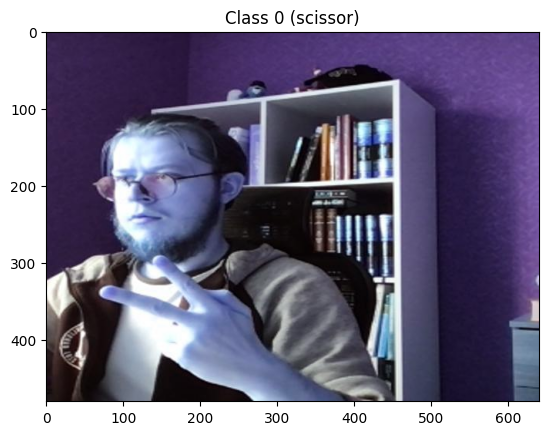

In [ ]:
draw_img(0)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

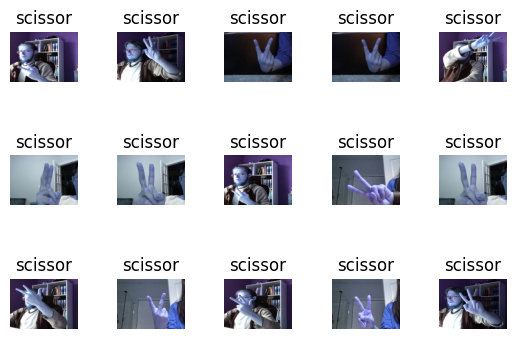

In [ ]:
draw_sample(X_train, y_train, 0,3,5)

## 4. Normalize and Encode Data

As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>

In [ ]:
## 4. Normalize and Encode Data
import numpy as np

seed = 7
np.random.seed(seed)

# Normalize the data
print(X_train.shape)
print(y_train.shape)

# The original data of each image is a 480x640x3 matrix of integers from 0 to 255.
# We need to scale it down to floats in the unit interval
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# One hot encode outputs
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
num_classes = Y_test.shape[1]

(96, 480, 640, 3)
(96,)


# Building Neural Network for the image set

The input layer would have to be of size 480x640x3. If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


## 5.  Train a Model

In [ ]:
## Make Model Assumptions
nb_epoch = 10
batch_size = 4
model_name="baseline_1"

In [ ]:
## Define Model Architecture
model1 = Sequential()
model1.add(Convolution2D(4, 2, 2, input_shape=(480, 640, 3), activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model1.add(Convolution2D(8, 2, 2, activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model1.add(Flatten())
model1.add(Dense(32, activation='relu')) # add parameters and activation function
model1.add(Dense(nb_classes, activation='softmax')) # activation function


In [ ]:
## Compile Model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 4)       52        
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 160, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 8)         136       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 40, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 32)                3

## 6. Save Model

In [ ]:
## 6. Save Model
# save the model if it's needed (and copy this to keep track of different versions)
# short description ->
model_dir="/content/gdrive/My Drive/rps/models"

if not os.path.exists(model_dir):
  os.makedirs(model_dir, exist_ok=True)

print(f"Saving model1 to {model_dir}/{model_name}.keras")
model1.save(f"{model_dir}/{model_name}.keras")

Saving model1 to /content/gdrive/My Drive/rps/models/baseline_1.keras


## 7. Evaluate Model

In [ ]:
import cv2
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, jaccard_score, precision_score, recall_score, roc_auc_score, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
# change folder to add local helper functions
%cd '/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates'
import dlutils
import kerutils
from dlutils import *
from kerutils import *
%cd '/content/gdrive/My Drive/rps'

/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates
/content/gdrive/My Drive/rps


In [ ]:
# load model if not run recently or want to revert to past model
model_name="baseline_1"
#model_dir="/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates/models"
model1 = load_model(f"{model_dir}/{model_name}.keras")

In [ ]:
## 7. Evaluate Model

# helper functions
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("nb_epoch =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()

def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)

def view_loss(h):
    # Loss history graph
    plt.plot(h.history['loss'])
    if 'val_loss' in h.history:
        plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)

Training: accuracy   = 0.885417 loss = 0.441651


Validation: accuracy = 0.666667 loss = 0.843803
Params count: 307519
stop epoch = 9
nb_epoch = 10


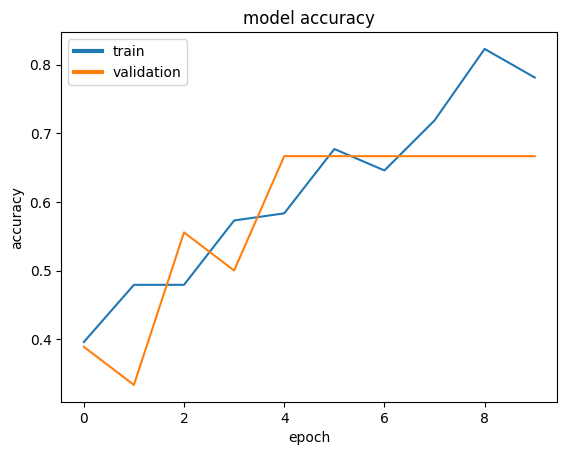

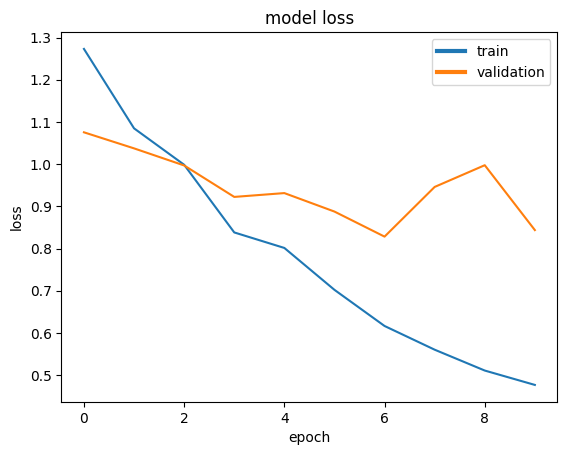

In [ ]:
## print both model accuracy and model loss by epoch
show_scores1(model1, h, X_train, Y_train, X_test, Y_test)

In [ ]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Training: accuracy = 1.000000  ;  loss = 0.068979
Validation: accuracy1 = 0.833333  ;  loss1 = 0.766771


**CONFUSION MATRIX** :  Contains True versus Predicted Vakues

In [ ]:
## CONFUSION MATRIX** :  Contains True versus Predicted Vakues

# Define classes
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

# Make predictions
predict_x = model1.predict(X_test)
y_pred = np.argmax(predict_x, axis=1)

# Convert numerical labels to class names
y_test_labels = [class_name[int(y)] for y in y_test]
y_pred_labels = [class_name[int(y)] for y in y_pred]

true_preds = [(x, y, p) for (x, y, p) in zip(X_test, y_test_labels, y_pred_labels) if y == p]
false_preds = [(x, y, p) for (x, y, p) in zip(X_test, y_test_labels, y_pred_labels) if y != p]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
classes = np.array(list(class_name.values()))

# Initialize the metrics dictionary
metrics = {
    'Class': [],
    'TP': [],
    'FN': [],
    'FP': [],
    'TN': [],
    'Recall': [],
    'Precision': [],
    'Accuracy': [],
    'F1 Score': [],
    'Specificity': [],
    'MCC': [],
    'Jaccard Index': []
}

# Calculate metrics for each class
for i, class_label in enumerate(classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN != 0 else 0
    f1 = f1_score(y_test_labels, y_pred_labels, labels=[class_label], average=None)[0]
    specificity = TN / (TN + FP) if TN + FP != 0 else 0
    mcc = matthews_corrcoef(y_test_labels, y_pred_labels)
    jaccard = jaccard_score(y_test_labels, y_pred_labels, labels=[class_label], average=None)[0]

    metrics['Class'].append(class_label)
    metrics['TP'].append(TP)
    metrics['FN'].append(FN)
    metrics['FP'].append(FP)
    metrics['TN'].append(TN)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['Accuracy'].append(accuracy)
    metrics['F1 Score'].append(f1)
    metrics['Specificity'].append(specificity)
    metrics['MCC'].append(mcc)
    metrics['Jaccard Index'].append(jaccard)

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)

# Show the DataFrame with all metrics
print(df_metrics)

# Save the DataFrame to a CSV file
df_metrics.to_csv(f"df_metrics_{model_name}_20240610.csv", index=False)

1/1 [==============================] - 0s 462ms/step
     Class  TP  FN  FP  TN    Recall  Precision  Accuracy  F1 Score  \
0  scissor   5   1   1  11  0.833333   0.833333  0.888889  0.833333   
1     rock   4   2   2  10  0.666667   0.666667  0.777778  0.666667   
2    paper   3   3   3   9  0.500000   0.500000  0.666667  0.500000   

   Specificity  MCC  Jaccard Index  
0     0.916667  0.5       0.714286  
1     0.833333  0.5       0.500000  
2     0.750000  0.5       0.333333  


## 8. Inspect Output

Neverthelss, before we search for a new model, let's take a quick look on some of the cases that our model1 missed. It may give us hints on the strengths an weaknesses of NN models, and what we can expect from these artificial models.<br>
The predict_classes method is helpful for getting a vector (y_pred) of the predicted classes of model1. We should compare y_pred to the expected true classes y_test in order to get the false cases:

**MAKE PREDICTIONS**: This is were the model is applied to the dataset

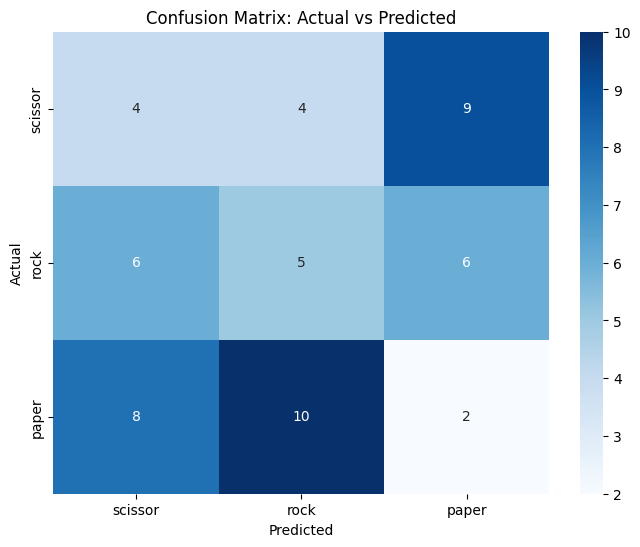

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, jaccard_score

# Define classes
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

# For demonstration, creating sample data with 54 predictions
np.random.seed(42)
y_test = np.random.choice([0, 1, 2], size=54)
y_pred = np.random.choice([0, 1, 2], size=54)

# Convert numerical labels to class names
y_test_labels = [class_name[int(y)] for y in y_test]
y_pred_labels = [class_name[int(y)] for y in y_pred]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
classes = np.array(list(class_name.values()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Actual vs Predicted')
plt.show()

chart_file_path = f"{model_dir}/confusion_matrix.png"
plt.savefig(chart_file_path)

**NORMALIZED CONFUSION MATRIX** : Use this to research what types of errors are being made.

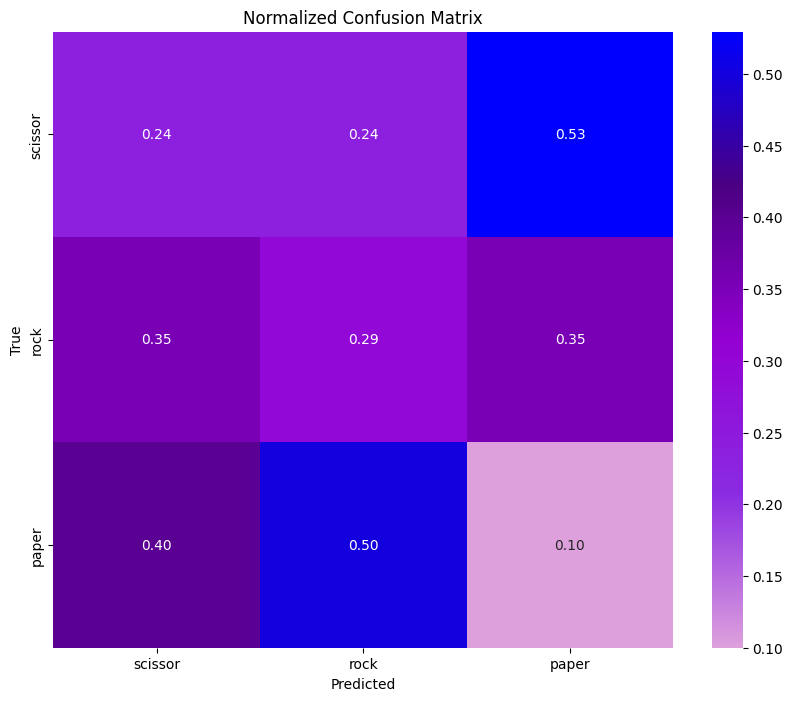

<Figure size 640x480 with 0 Axes>

In [ ]:
## NORMALIZED CONFUSION MATRIX : Use this to research what types of errors are being made.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assuming conf_matrix and classes are already defined
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define a custom colormap with five phases
# colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']  # red to green spectrum
# Define a custom colormap with five phases
# colors = ['#0000ff', '#4b0082', '#9400d3', '#8a2be2', '#dda0dd']  # Blue to purple spectrum
colors = ['#dda0dd', '#8a2be2', '#9400d3', '#4b0082', '#0000ff']  # purple to Blue  spectrum
#colors = ['#d3d3d3', '#b0b0b0', '#808080', '#585858', '#404040']  # Light gray to medium gray spectrum

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

chart_file_path = f"{model_dir}/normalized_confusion_matrix.png"
plt.savefig(chart_file_path)

**TRUE PREDICTION IMAGES** : Where are the images being clearly matched.

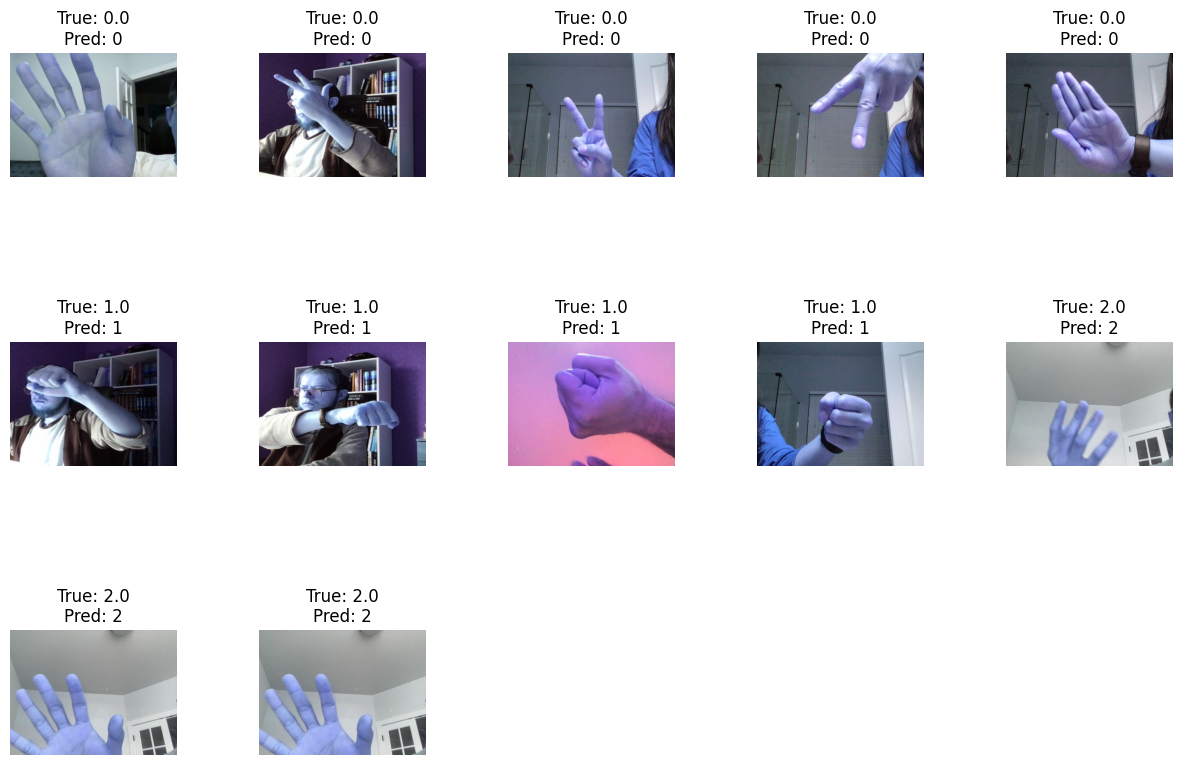

In [ ]:
# Visualize true predictions
plt.figure(figsize=(15, 10))
for i, (x, y, p) in enumerate(true_preds[0:15]):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x)
    plt.title(f"True: {y}\nPred: {p}", fontsize=12)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

chart_file_path = f"{model_dir}/true_predictions.png"
plt.savefig(chart_file_path)

**FALSE PREDICTION IMAGES** : Let's see images we can not recognize.  These should probably be replaced.

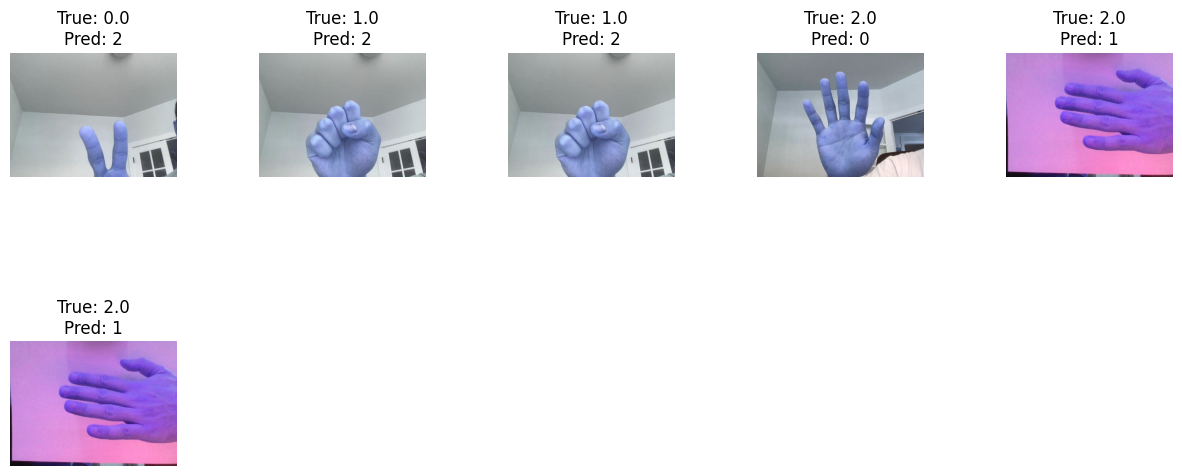

In [ ]:
# Visualize false predictions
plt.figure(figsize=(15, 10))
for i, (x, y, p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x)
    plt.title(f"True: {y}\nPred: {p}", fontsize=12)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

chart_file_path = f"{model_dir}/false_predictions.png"
plt.savefig(chart_file_path)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()